<a href="https://colab.research.google.com/github/dangcaptkd2/PracticeWithTensorFlow/blob/main/Basic_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We'll train a binary classifier to perform sentiment analysis on an IMDB dataset.

In [1]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import preprocessing
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
print(tf.__version__)

2.4.1


# Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as positive or negative, based on the text of the review.

## Download and explore the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.

In [3]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1.tar.gz", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

84131840/84125825 [==============================] - 1s 0us/step


In [4]:
os.listdir(dataset_dir)

['imdb.vocab', 'README', 'imdbEr.txt', 'test', 'train']

In [5]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['unsupBow.feat',
 'labeledBow.feat',
 'urls_unsup.txt',
 'urls_pos.txt',
 'pos',
 'neg',
 'unsup',
 'urls_neg.txt']


The aclImdb/train/pos and aclImdb/train/neg directories contain many text files, each of which is a single movie review. Let's take a look at one of them.

In [6]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


## Load the dataset

To prepare a dataset for binary classification, you will need two folders on disk, corresponding to class_a and class_b. These will be the positive and negative movie reviews, which can be found in aclImdb/train/pos and aclImdb/train/neg. As the IMDB dataset contains additional folders, you will remove them before using this utility.

In [7]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

Next, you will use the text_dataset_from_directory utility to create a labeled tf.data.Dataset. tf.data is a powerful collection of tools for working with data.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the validation_split argument below.

In [8]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


In [9]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

Notice the reviews contain raw text (with punctuation and occasional HTML tags like < br / > ).

The labels are 0 or 1. To see which of these correspond to positive and negative movie reviews, we can check the class_names property on the dataset.

In [10]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


Create a validation and test dataset. We will use the remaining 5,000 reviews from the training set for validation.

Note: When using the validation_split and subset arguments, make sure to either specify a random seed, or to pass shuffle=False, so that the validation and training splits have no overlap.

In [11]:
raw_val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [12]:
raw_test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


## Prepare the dataset for training

Standardize, tokenize, and vectorize the data using the helpful preprocessing.TextVectorization layer.

Standardization refers to preprocessing the text, typically to remove punctuation or HTML elements to simplify the dataset. Tokenization refers to splitting strings into tokens (for example, splitting a sentence into individual words, by splitting on whitespace). Vectorization refers to converting tokens into numbers so they can be fed into a neural network.

As we saw above, the reviews contain various HTML tags like <br />. These tags will not be removed by the default standardizer in the TextVectorization layer (which converts text to lowercase and strips punctuation by default, but doesn't strip HTML). We will write a custom standardization function to remove the HTML

In [13]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,'[%s]' % re.escape(string.punctuation),'')

Create a TextVectorization layer. you will use this layer to standardize, tokenize, and vectorize our data. We set the output_mode to int to create unique integer indices for each token.

In [14]:
max_features = 10000
sequence_length = 250

vectorize_layer = TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

In [15]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

Let's create a function to see the result of using this layer to preprocess some data.

In [16]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [17]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review:", first_review)
print("Label:", raw_train_ds.class_names[first_label])
print("Vectorized review:", vectorize_text(first_review, first_label))

Review: tf.Tensor(b'Silent Night, Deadly Night 5 is the very last of the series, and like part 4, it\'s unrelated to the first three except by title and the fact that it\'s a Christmas-themed horror flick.<br /><br />Except to the oblivious, there\'s some obvious things going on here...Mickey Rooney plays a toymaker named Joe Petto and his creepy son\'s name is Pino. Ring a bell, anyone? Now, a little boy named Derek heard a knock at the door one evening, and opened it to find a present on the doorstep for him. Even though it said "don\'t open till Christmas", he begins to open it anyway but is stopped by his dad, who scolds him and sends him to bed, and opens the gift himself. Inside is a little red ball that sprouts Santa arms and a head, and proceeds to kill dad. Oops, maybe he should have left well-enough alone. Of course Derek is then traumatized by the incident since he watched it from the stairs, but he doesn\'t grow up to be some killer Santa, he just stops talking.<br /><br />

As we can see above, each token has been replaced by an integer. You can lookup the token (string) that each integer corresponds to by calling .get_vocabulary() on the layer.

In [18]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


We are nearly ready to train your model. As a final preprocessing step, you will apply the TextVectorization layer you created earlier to the train, validation, and test dataset

In [19]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

## Configure the dataset for performance

These are two important methods we should use when loading data to make sure that I/O does not become blocking.

.cache() keeps data in memory after it's loaded off disk. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache, which is more efficient to read than many small files.

.prefetch() overlaps data preprocessing and model execution while training.

In [20]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Create the model

In [21]:
embedding_dim = 16

In [22]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          160016    
_________________________________________________________________
dropout (Dropout)            (None, None, 16)          0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 16)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


## Loss function and optimizer

A model needs a loss function and an optimizer for training. Since this is a binary classification problem and the model outputs a probability (a single-unit layer with a sigmoid activation), you'll use losses.BinaryCrossentropy loss function.

In [23]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

## Train the model

In [24]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10
625/625 [==============================] - 10s 15ms/step - loss: 0.6811 - binary_accuracy: 0.6133 - val_loss: 0.6119 - val_binary_accuracy: 0.7762
Epoch 2/10
625/625 [==============================] - 3s 5ms/step - loss: 0.5770 - binary_accuracy: 0.7849 - val_loss: 0.4962 - val_binary_accuracy: 0.8228
Epoch 3/10
625/625 [==============================] - 3s 5ms/step - loss: 0.4640 - binary_accuracy: 0.8358 - val_loss: 0.4187 - val_binary_accuracy: 0.8486
Epoch 4/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3904 - binary_accuracy: 0.8608 - val_loss: 0.3726 - val_binary_accuracy: 0.8614
Epoch 5/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3422 - binary_accuracy: 0.8754 - val_loss: 0.3441 - val_binary_accuracy: 0.8682
Epoch 6/10
625/625 [==============================] - 3s 5ms/step - loss: 0.3092 - binary_accuracy: 0.8881 - val_loss: 0.3249 - val_binary_accuracy: 0.8732
Epoch 7/10
625/625 [==============================] - 3s 5ms/s

## Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents our error, lower values are better), and accuracy.

In [25]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

782/782 [==============================] - 8s 10ms/step - loss: 0.3101 - binary_accuracy: 0.8741
Loss:  0.3101245164871216
Accuracy:  0.8741199970245361


## Create a plot of accuracy and loss over time

In [26]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

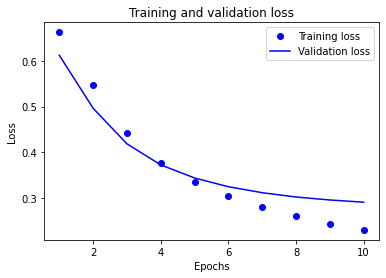

In [27]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


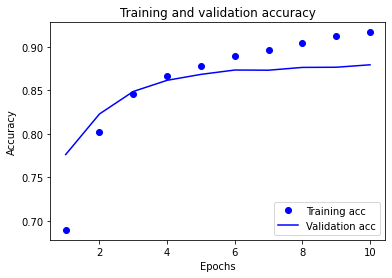

In [28]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

## Export the model

In the code above, we applied the TextVectorization layer to the dataset before feeding text to the model. If u want to make your model capable of processing raw strings (for example, to simplify deploying it), we can include the TextVectorization layer inside your model. To do so, u can create a new model using the weights you just trained.

In [29]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)
# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

782/782 [==============================] - 9s 11ms/step - loss: 0.3097 - accuracy: 0.8736
0.8741199970245361


## Inference on new data

In [30]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

array([[0.6280352 ],
       [0.45011684],
       [0.3662237 ]], dtype=float32)